In [103]:
import time

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from treesampling import algorithms
from treesampling.utils.graphs import random_uniform_graph, random_tree_skewed_graph, tuttes_tot_weight, normalize_graph_weights, reset_adj_matrix, tree_to_newick, graph_weight

# Tree sampling analysis

In [104]:
def sampling_coverage_test(k_vals: list, sample_size: int = 2000, root: int = 0, skew_factor: int = 100, log_scale: bool = False, verbose: bool = True):
    """
    Perform experiment for a number of different graph sizes
    :param k_vals: graph sizes (number of nodes)
    :param sample_size: size of sample (number of draws)
    :param root: label of node to be chosen as root
    :param skew_factor: a random tree is sampled, then weights of those edges compared to the rest is x:1 
    :param log_scale: wheter to use log or non-log scale weigth matrix (and algorithm)
    :param verbose: prints some stats while running
    :return: pandas dataframe with a record for each unseen tree
    """
    records = []
    
    for n_nodes in k_vals:
        graph, target_tree = random_tree_skewed_graph(n_nodes, skew_factor)
        target_tree_nwk = tree_to_newick(target_tree)
        mst_nwk = tree_to_newick(nx.maximum_spanning_arborescence(graph))
        if verbose:
            print(f"{n_nodes} nodes graph skewed towards: {target_tree_nwk}")
            print(f"MST: {mst_nwk}" + (" different!" if target_tree_nwk != mst_nwk else ""))
        norm_graph = normalize_graph_weights(graph, rowwise=False)
        tot_weight = tuttes_tot_weight(norm_graph, root)
        log_graph = reset_adj_matrix(graph, np.log(nx.to_numpy_array(graph)))

        sample = {}
        acc_w = 0
        target_cnt = 0
        num = 0
        for i in range(sample_size):
            # run sampling of one tree
            start_time = time.time()
            if log_scale:
                tree = algorithms.jens_rst_log(log_graph, root=root)
            else:
                tree = algorithms.jens_rst(graph, root=root)
            end_time = time.time() - start_time
            
            # record
            tree_nwk = tree_to_newick(tree)
            if tree_nwk == target_tree_nwk:
                target_cnt += 1
            if tree_nwk not in sample:
                weight = np.exp(graph_weight(tree, log_probs=True)) if log_scale else graph_weight(tree)
                tree_prob = weight / tot_weight
                sample[tree_nwk] = weight
                acc_w += weight
                num += 1
                records.append([i, acc_w / tot_weight, tree_prob, num, n_nodes, skew_factor, end_time])
        if verbose:
            print(f" target_cnt ({target_cnt}) / sample_size ({sample_size}) = {target_cnt / sample_size}")

    out_df = pd.DataFrame(records, columns=['n_draws', 'acc_prob', 'tree_prob', 'acc_discovery', 'n_nodes', 'skew_factor', 'time'])
    return out_df

res_df = sampling_coverage_test(k_vals=[6, 7, 8, 9, 10], sample_size=5000)

6 nodes graph skewed towards: (((3)2)1,(4)5)0
MST: (((3)2)1,(4)5)0
 target_cnt (4288) / sample_size (5000) = 0.8576
7 nodes graph skewed towards: (3,(((1)4)2)5,6)0
MST: (3,(((1)4)2)5,6)0
 target_cnt (3986) / sample_size (5000) = 0.7972
8 nodes graph skewed towards: (1,(((4,7)6)2,3)5)0
MST: (1,(((4,7)6)2,3)5)0
 target_cnt (3665) / sample_size (5000) = 0.733
9 nodes graph skewed towards: (((6)2,3,4)1,5,(8)7)0
MST: (((6)2,3,4)1,5,(8)7)0
 target_cnt (3028) / sample_size (5000) = 0.6056
10 nodes graph skewed towards: (((((((4)1)8)5,6,7)3)2)9)0
MST: (((((((4)1)8)5,6,7)3)2)9)0
 target_cnt (3227) / sample_size (5000) = 0.6454


## Time
For each graph size, plot the average time (in seconds) required for one sample

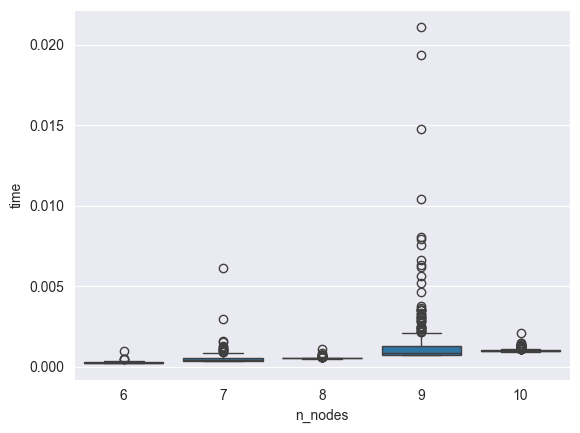

In [105]:
g = sns.boxplot(res_df, x='n_nodes', y='time')

## Cumulative probability
For each size of the graph, draw the cumulative probability after each new tree is found. The quicker it reaches 1, the better.
If it plateaus, it means that new trees are rarely found.

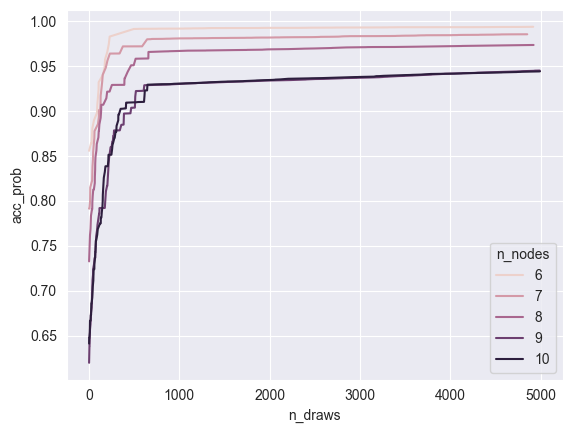

In [106]:
g = sns.lineplot(res_df, x='n_draws', y='acc_prob', hue='n_nodes')

## Residual probability analysis
Where it plateaus, the residual probability mass should be similar to the proportion of unseen trees that are sampled.
To determine a pleateau, we compute the increment in cumulative prob by the number of draws (increment ratio). And we fix a threshold for the incremental ratio.

[K=6 - after 495 draws] residual prob v. new tree rate: 0.008570332789835655 | 0.007090576395242452
[K=7 - after 665 draws] residual prob v. new tree rate: 0.019989131333768895 | 0.018967587034813924
[K=8 - after 669 draws] residual prob v. new tree rate: 0.03415127397927109 | 0.027803958529688973
[K=9 - after 620 draws] residual prob v. new tree rate: 0.07116530727510728 | 0.06914771422007811
[K=10 - after 661 draws] residual prob v. new tree rate: 0.0705568576137543 | 0.06281872971719982


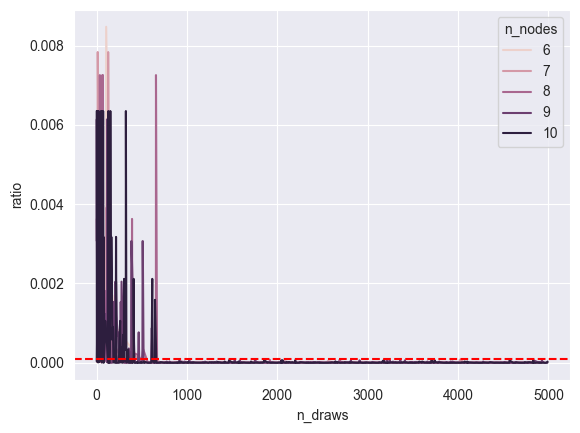

In [107]:
dyx = res_df.groupby(['n_nodes'])[['n_draws', 'acc_prob']].diff().fillna(0)
res_df['ratio'] = dyx['acc_prob'] / dyx['n_draws']
thresh = 0.0001
g = sns.lineplot(res_df, x='n_draws', y='ratio', hue='n_nodes')
g.axhline(thresh, color='red', linestyle='--')

res_df['thresh'] = (res_df['ratio'] < thresh).astype('int').diff().fillna(0)
elbows = res_df[res_df['thresh'] > 0].groupby('n_nodes').tail(1)[['n_nodes', 'n_draws', 'acc_prob']].values.tolist()

for n_nodes, n_draws, acc_prob in elbows:
    new_tree_rate = 1 / res_df[(res_df['n_nodes'] == int(n_nodes)) & (res_df['n_draws'] > n_draws)]['n_draws'].diff().fillna(0).mean()
    print(f'[K={int(n_nodes)} - after {int(n_draws)} draws] residual prob v. new tree rate: {1 - acc_prob} | {new_tree_rate}')



MAKE TEST: some trees are more difficult to sample than others, just based on the topology

In [108]:
res_df[res_df['n_nodes'] == 10]

,n_draws,acc_prob,tree_prob,acc_discovery,n_nodes,skew_factor,time,ratio,thresh
717,0,0.641140,6.411401e-01,1,10,100,0.001345,NaN,-1.0
718,1,0.647488,6.347922e-03,2,10,100,0.001275,6.347922e-03,0.0
719,3,0.647551,6.285071e-05,3,10,100,0.002131,3.142535e-05,1.0
720,8,0.653899,6.347922e-03,4,10,100,0.001256,1.269584e-03,-1.0
721,9,0.660247,6.347922e-03,5,10,100,0.001342,6.347922e-03,0.0
...,...,...,...,...,...,...,...,...,...
1082,4941,0.944108,6.222843e-07,366,10,100,0.001021,1.244569e-07,0.0
1083,4971,0.944109,6.222843e-07,367,10,100,0.001037,2.074281e-08,0.0
1084,4982,0.944171,6.285071e-05,368,10,100,0.001039,5.713701e-06,0.0
1085,4989,0.944234,6.285071e-05,369,10,100,0.001105,8.978673e-06,0.0


<Axes: >

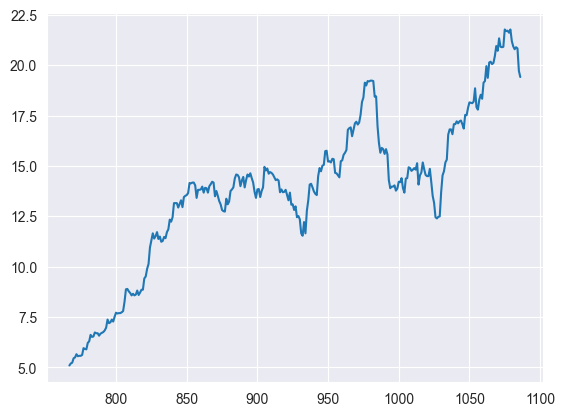

In [109]:
# plot rolling average of draws before a new unseen tree (every point on x is a new tree)
res_df[res_df['n_nodes'] == 10]['n_draws'].diff().rolling(window=50).mean().plot()

# Direction test
> test consistency of direction of arcs between W table and last-exit probabilities

In [110]:
# build graph with high probs in one direction and low in the opposite
# e.g. high prob for i->i+

n_nodes = 8
graph = nx.complete_graph(n_nodes, create_using=nx.DiGraph)
asc_mat = np.ones((n_nodes, n_nodes))
np.fill_diagonal(asc_mat, 0)
asc_mat += 299 * np.triu(asc_mat)
# asc_mat[5,:] = 0
graph = reset_adj_matrix(graph, matrix=asc_mat)
# graph = normalize_graph_weights(graph, rowwise=False)
print("Unbalanced graph:")
print(nx.to_numpy_array(graph))

ss = 1000
trees = []
for _ in range(ss):
    samp_tree = algorithms.jens_rst(graph, root=0)
    trees.append(samp_tree)



Unbalanced graph:
[[  0. 300. 300. 300. 300. 300. 300. 300.]
 [  1.   0. 300. 300. 300. 300. 300. 300.]
 [  1.   1.   0. 300. 300. 300. 300. 300.]
 [  1.   1.   1.   0. 300. 300. 300. 300.]
 [  1.   1.   1.   1.   0. 300. 300. 300.]
 [  1.   1.   1.   1.   1.   0. 300. 300.]
 [  1.   1.   1.   1.   1.   1.   0. 300.]
 [  1.   1.   1.   1.   1.   1.   1.   0.]]


In [111]:
acc = 0
for t in trees:
    high_prob_arcs = sum([1 if u < v else 0 for u,v in t.edges()])
    print(f'{tree_to_newick(t)}: {graph_weight(t)} - {high_prob_arcs} / {n_nodes - 1}')
    acc += high_prob_arcs
print(f'avg {acc / len(trees)} high prob arcs')

((2)1,(4)3,5,(7)6)0: 0.00019122073530709015 - 7 / 7
((4)1,((5,6,7)3)2)0: 0.00019122073530709012 - 7 / 7
(1,((7)3,(6)5)2,4)0: 0.00019122073530709017 - 7 / 7
((6)1,(3)2,4,(7)5)0: 0.00019122073530709017 - 7 / 7
(((6)2,((7)5)4)1,3)0: 0.00019122073530709015 - 7 / 7
((((5)3)2,4)1,6,7)0: 0.00019122073530709015 - 7 / 7
((3,7)1,(4)2,(6)5)0: 0.00019122073530709017 - 7 / 7
(1,(5)2,(7)3,(6)4)0: 0.00019122073530709015 - 7 / 7
(((6)2)1,3,((7)5)4)0: 0.00019122073530709015 - 7 / 7
((2,((5)4,(7)6)3)1)0: 0.00019122073530709012 - 7 / 7
((((5)3)2,4)1,(7)6)0: 0.00019122073530709017 - 7 / 7
(1,((6)4)2,(7)3,5)0: 0.00019122073530709017 - 7 / 7
((6)1,(4,7)2,3,5)0: 0.00019122073530709015 - 7 / 7
((5)1,(4)2,(7)3,6)0: 0.00019122073530709012 - 7 / 7
((((4,5)3,7)2)1,6)0: 0.00019122073530709015 - 7 / 7
((((7)6)5)1,(4)2,3)0: 0.00019122073530709015 - 7 / 7
(((6)3,7)1,(5)2,4)0: 0.00019122073530709017 - 7 / 7
((5)1,((6,7)3)2,4)0: 0.00019122073530709015 - 7 / 7
((4)1,2,(((7)6)5)3)0: 0.00019122073530709015 - 7 / 7
(((7)2,